# Breast cancer survival prediction - master thesis

### Dataset: TCGA, PanCancer Atlas 2018

### Libriaries import

In [1529]:
#Basic libraries
import numpy as np
import pandas as pd
from scipy import stats
import textwrap as twp
from collections import Counter

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yellowbrick as yb
from matplotlib.colors import ListedColormap
from yellowbrick.classifier import ROCAUC
from matplotlib_venn import venn3
import matplotlib.patches as mpatches
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler


from IPython.display import set_matplotlib_formats 
plt.style.use('ggplot')
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")


# Pallets used for visualizations
color= "Spectral"
color_plt = ListedColormap(sns.color_palette(color).as_hex())
color_hist = 'teal'
two_colors = [ sns.color_palette(color)[5], sns.color_palette(color)[0]]


### Data Upload and preparation

Clinical data description:

In [1530]:
clinical_description = pd.read_csv('/Users/Marta/Desktop/magisterka/dataset/brca_tcga_pan_can_atlas_2018/data_clinical_patient_description.txt', delimiter="\t").transpose()

In [1531]:
pd.set_option("display.max_colwidth", -1)

In [1532]:
clinical_description.reset_index(inplace = True)

In [1533]:
clinical_description.columns = ['Name', 'Description']

In [1534]:
clinical_description.style.hide_index().set_properties(**{'text-align': 'left'}).set_table_styles([ dict(selector='th', props=[('text-align', 'left')] ) ])

Name,Description
Patient Identifier,Identifier to uniquely specify a patient.
Subtype,Subtype
TCGA PanCanAtlas Cancer Type Acronym,Text field to hold cancer type acronym used by TCGA PanCanAtlas.
Other Patient ID,Legacy DMP patient identifier (DMPnnnn)
Diagnosis Age,Age at which a condition or disease was first diagnosed.
Sex,Sex
Neoplasm Disease Stage American Joint Committee on Cancer Code,"The extent of a cancer, especially whether the disease has spread from the original site to other parts of the body based on AJCC staging criteria."
American Joint Committee on Cancer Publication Version Type,"The version or edition of the American Joint Committee on Cancer Cancer Staging Handbooks, a publication by the group formed for the purpose of developing a system of clinical staging for cancer that is acceptable to the American medical profession and is compatible with other accepted classifications."
Last Communication Contact from Initial Pathologic Diagnosis Date,"Time interval from the date of last followup to the date of initial pathologic diagnosis, represented as a calculated number of days.."
Birth from Initial Pathologic Diagnosis Date,"Time interval from a person's date of birth to the date of initial pathologic diagnosis, represented as a calculated number of days."


In [1535]:
clinical = pd.read_csv('/Users/Marta/Desktop/magisterka/dataset/brca_tcga_pan_can_atlas_2018/data_clinical_patient.txt', delimiter="\t")
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 37 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   PATIENT_ID                                  1084 non-null   object 
 1   SUBTYPE                                     981 non-null    object 
 2   CANCER_TYPE_ACRONYM                         1084 non-null   object 
 3   OTHER_PATIENT_ID                            1084 non-null   object 
 4   AGE                                         1084 non-null   int64  
 5   SEX                                         1084 non-null   object 
 6   AJCC_PATHOLOGIC_TUMOR_STAGE                 1079 non-null   object 
 7   AJCC_STAGING_EDITION                        944 non-null    object 
 8   DAYS_LAST_FOLLOWUP                          980 non-null    float64
 9   DAYS_TO_BIRTH                               1069 non-null   float64
 10  DAYS_TO_INIT

In [1536]:
clinical.drop(labels = ['CANCER_TYPE_ACRONYM',
'OTHER_PATIENT_ID',
'DAYS_LAST_FOLLOWUP',
'AJCC_STAGING_EDITION',
'WEIGHT',
'RADIATION_THERAPY',
'DAYS_TO_BIRTH',
'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS',
'ETHNICITY',
'FORM_COMPLETION_DATE',
'ICD_O_3_SITE',
'INFORMED_CONSENT_VERIFIED',
'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT',
'PERSON_NEOPLASM_CANCER_STATUS',
'IN_PANCANPATHWAYS_FREEZE',
'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT'], axis=1, inplace=True)

In [1537]:
clinical_sample = pd.read_csv('/Users/Marta/Desktop/magisterka/dataset/brca_tcga_pan_can_atlas_2018/data_clinical_sample.txt', delimiter="\t")
# clinical_sample.info()

In [1538]:

clinical_sample = clinical_sample[['PATIENT_ID', 'SAMPLE_ID', 'ONCOTREE_CODE', 'TUMOR_TYPE', 'ANEUPLOIDY_SCORE']]
# clinical_sample.head()

In [1539]:
clinical_supp_hypoxia = pd.read_csv('/Users/Marta/Desktop/magisterka/dataset/brca_tcga_pan_can_atlas_2018/data_clinical_supp_hypoxia.txt', delimiter="\t")
clinical_supp_hypoxia = clinical_supp_hypoxia[['PATIENT_ID', 'WINTER_HYPOXIA_SCORE']]
clinical_supp_hypoxia.head()

,PATIENT_ID,WINTER_HYPOXIA_SCORE
0,TCGA-3C-AAAU,-28
1,TCGA-3C-AALI,20
2,TCGA-3C-AALJ,-10
3,TCGA-3C-AALK,4
4,TCGA-4H-AAAK,-20


In [1541]:
mutations = pd.read_csv('/Users/Marta/Desktop/magisterka/dataset/brca_tcga_pan_can_atlas_2018/Mutation_Count.txt', delimiter="\t")
mutations = mutations.drop(labels = 'Study ID', axis = 1)
mutations.columns = ['PATIENT_ID', 'SAMPLE_ID', 'MUTATION_COUNT']

In [1542]:
fraction_genome_altered = pd.read_csv('/Users/Marta/Desktop/magisterka/dataset/brca_tcga_pan_can_atlas_2018/Mutation_Count_vs_Fraction_Genome_Altered.txt', delimiter="\t")
fraction_genome_altered = fraction_genome_altered.drop(labels = ['Cancer Study', 'Mutation Count'], axis = 1)
fraction_genome_altered.columns = ['PATIENT_ID', 'SAMPLE_ID', 'FRACTION_GENOME_ALTERED']

In [1543]:
data_timeline_sample_acquisition= pd.read_csv('/Users/Marta/Desktop/magisterka/dataset/brca_tcga_pan_can_atlas_2018/data_timeline_sample_acquisition.txt', delimiter="\t")
data_timeline_sample_acquisition.drop(labels = ['START_DATE', 'STOP_DATE', 'SAMPLE_PRESCREENED', 'TOP_SLIDE_SUBMITTED', 'VESSEL_USED', 'EVENT_TYPE', 'METHOD_OF_SAMPLE_PROCUREMENT'], axis=1, inplace=True)
data_timeline_sample_acquisition.drop_duplicates(inplace=True)

In [1544]:
data_timeline_treatment = pd.read_csv('/Users/Marta/Desktop/magisterka/dataset/brca_tcga_pan_can_atlas_2018/data_timeline_treatment.txt', delimiter="\t")

In [1545]:
data_timeline_treatment = data_timeline_treatment[['PATIENT_ID', 'TREATMENT_TYPE']]

unique_list = []
      
for x in data_timeline_treatment['TREATMENT_TYPE']:
    if x not in unique_list:
         unique_list.append(x)


for i in range(6):
    data_timeline_treatment[unique_list[i]] = np.where(data_timeline_treatment['TREATMENT_TYPE'] == unique_list[i], 1, 0)

In [1546]:
data_timeline_treatment = data_timeline_treatment.drop(labels = ['TREATMENT_TYPE'], axis=1).drop_duplicates().groupby('PATIENT_ID').sum()


In [1547]:
data_timeline_treatment.columns = ['CHEMOTHERAPY', 'OTHER', 'RADIATION THERAPY', 'HORMONE THERAPY', 'TARGETED MOLECULAR THERAPY', 'IMMUNOTHERAPY']

In [1548]:
join1 = pd.merge(clinical, clinical_sample, how="left", on='PATIENT_ID')


In [1549]:
join2 = pd.merge(join1, clinical_supp_hypoxia, how="left", on='PATIENT_ID')

In [1550]:
join3 = pd.merge(join2, mutations, how="left", on = ['PATIENT_ID', 'SAMPLE_ID'])

In [1551]:
join4 = pd.merge(join3, data_timeline_sample_acquisition, how="left", on = ['PATIENT_ID', 'SAMPLE_ID'])

In [1552]:
join5 = pd.merge(join4, data_timeline_treatment, how="left", on = 'PATIENT_ID')

In [1553]:
df = pd.merge(join5, fraction_genome_altered, how="left", on = ['PATIENT_ID', 'SAMPLE_ID'])

In [1554]:
df.drop(labels = ['SAMPLE_ID'], axis = 1, inplace = True)

In [1555]:
df['PFS_STATUS'] = np.where(df['PFS_STATUS'] == '0:CENSORED', 0, df['PFS_STATUS'])
df['PFS_STATUS'] = np.where(df['PFS_STATUS'] == '1:PROGRESSION', 1, df['PFS_STATUS'])
df['DFS_STATUS'] = np.where(df['DFS_STATUS'] == '0:DiseaseFree', 0, df['DFS_STATUS'])
df['DFS_STATUS'] = np.where(df['DFS_STATUS'] == '1:Recurred/Progressed', 1, df['DFS_STATUS'])
df['DSS_STATUS'] = np.where(df['DSS_STATUS'] == '0:ALIVE OR DEAD TUMOR FREE', 0, df['DSS_STATUS'])
df['DSS_STATUS'] = np.where(df['DSS_STATUS'] == '1:DEAD WITH TUMOR', 1, df['DSS_STATUS'])
df['OS_STATUS'] = np.where(df['OS_STATUS'] == '0:LIVING', 0, 1)

In [1556]:

df[['PFS_STATUS', 'DFS_STATUS', 'DSS_STATUS']] = df[['PFS_STATUS', 'DFS_STATUS', 'DSS_STATUS']].apply(pd.to_numeric)

## Final dataset description

In [1557]:
df2 = df.drop(labels = ['DSS_STATUS','OS_MONTHS', 'DSS_MONTHS','DFS_STATUS','DFS_MONTHS', 'PFS_STATUS', 'PFS_MONTHS', 'PATIENT_ID'], axis=1)
df2['COUNTRY'].sort_values().unique()

array(['Afghanistan', 'Brazil', 'Canada', 'Germany', 'Moldova', 'Nigeria',
       'Pakistan', 'Poland', 'Russia', 'Ukraine', 'United States',
       'Vietnam', nan], dtype=object)

In [1558]:
#Finding missing data and the percentage of it in each column
total = df2.isnull().sum().sort_values(ascending = False)
percent = (df2.isnull().sum() * 100 / df2.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total Missing Values', 'Percent Missing values'])
missing_data.head(19)

,Total Missing Values,Percent Missing values
COUNTRY,399,36.808118
IMMUNOTHERAPY,294,27.121771
TARGETED MOLECULAR THERAPY,294,27.121771
HORMONE THERAPY,294,27.121771
RADIATION THERAPY,294,27.121771
OTHER,294,27.121771
CHEMOTHERAPY,294,27.121771
SUBTYPE,103,9.501845
RACE,90,8.302583
FRACTION_GENOME_ALTERED,90,8.302583


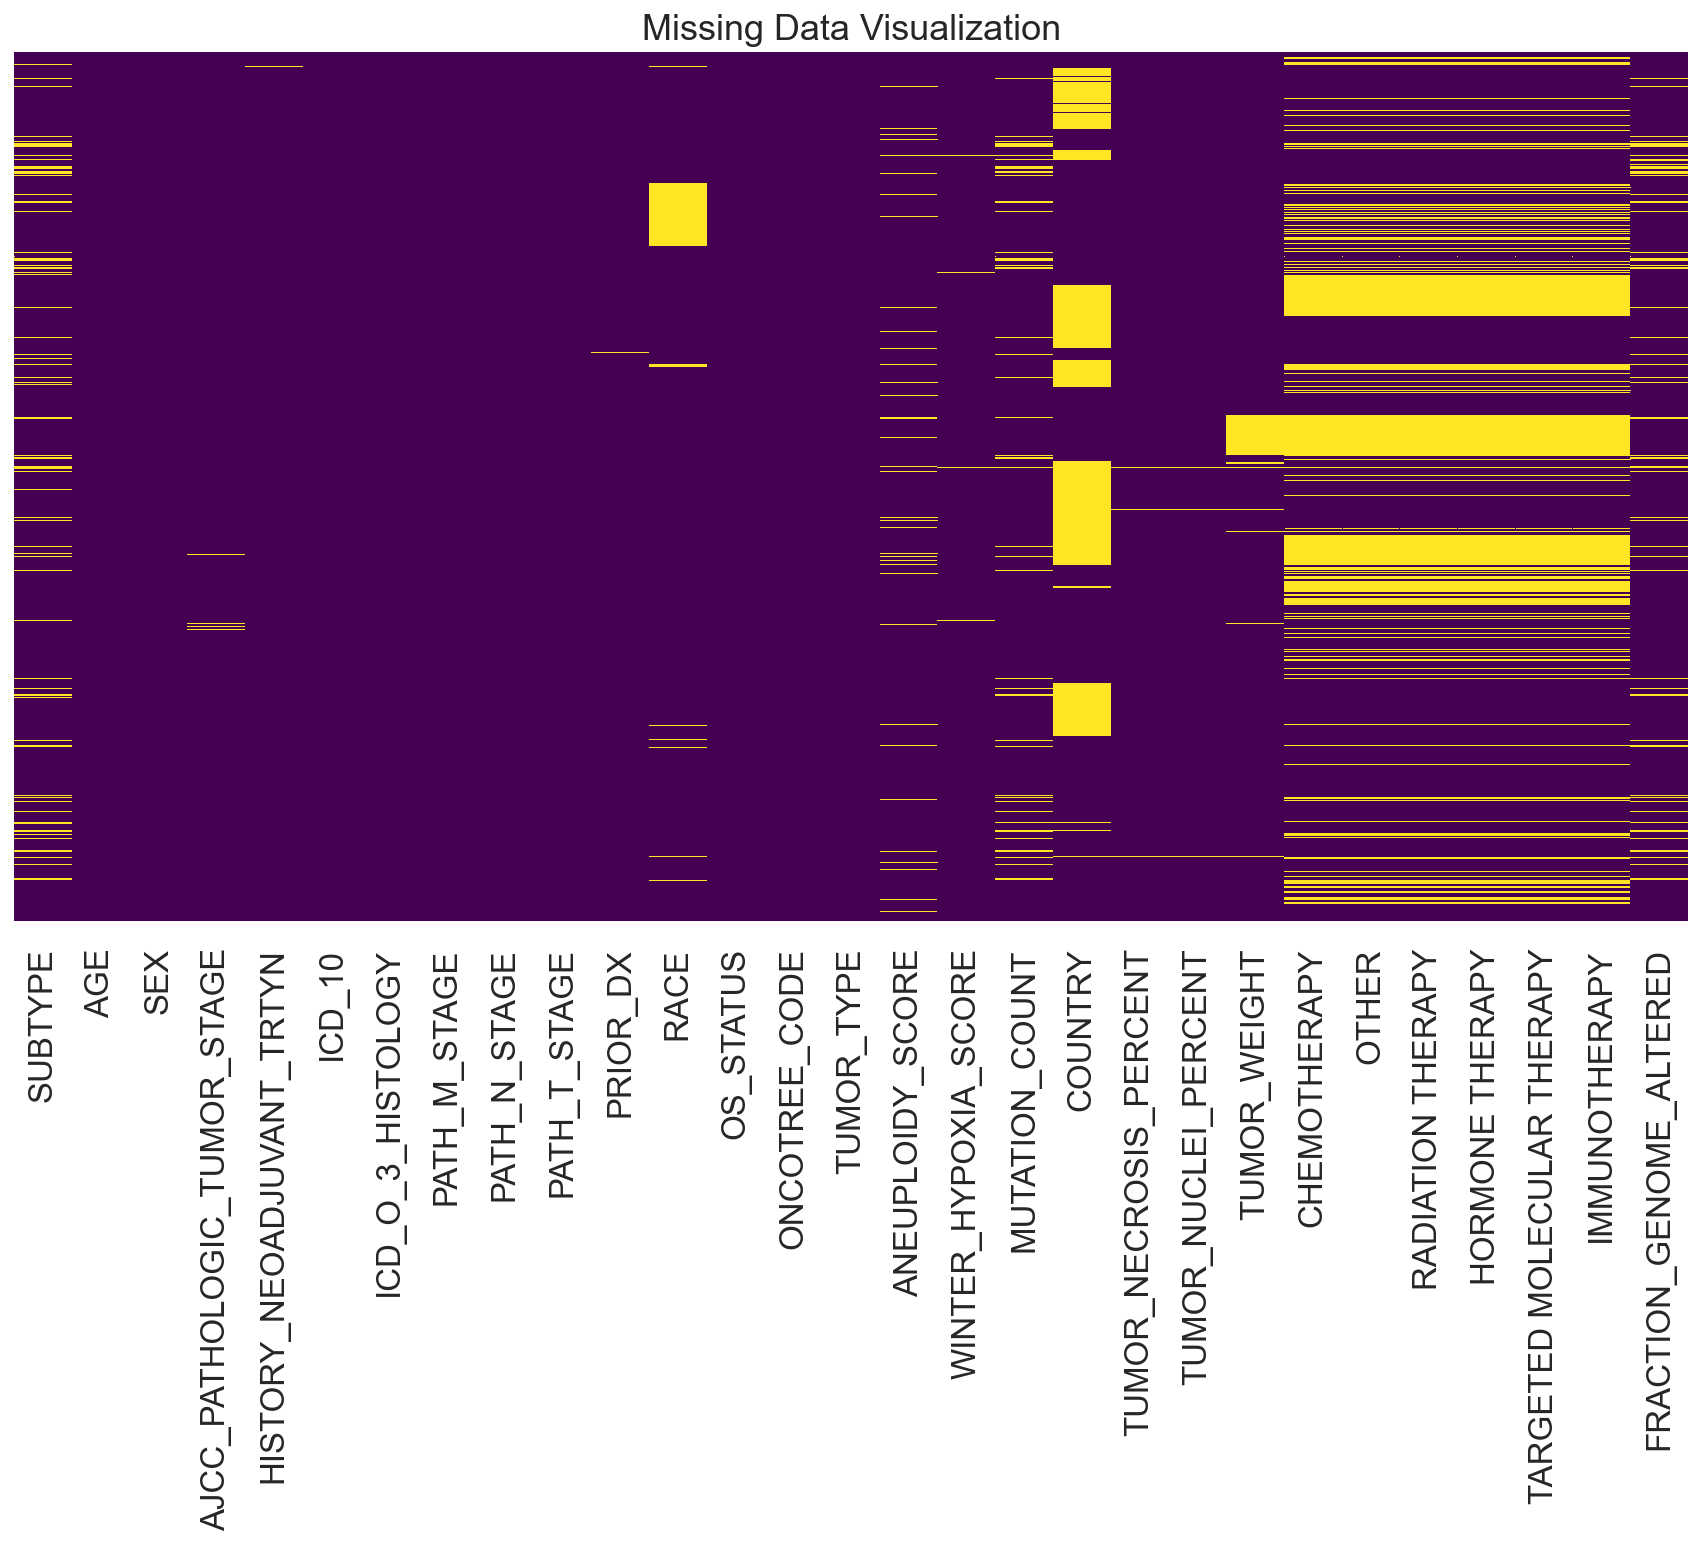

In [1559]:
# Visualization of missing data
fig, ax = plt.subplots( figsize = (15, 8))
sns.heatmap(df2.isnull(), yticklabels=False, cbar=False, cmap='viridis')
ax.set_title('Missing Data Visualization')
plt.show()

In [1560]:
df.drop(labels = ['PATIENT_ID'], axis=1, inplace=True)

### Exploratory Data Analysis and Data Visualization

#### a) Relationship between clinical attributes and outcomes

In [1561]:
final_df_numerical = df.select_dtypes(include=['number'])
final_df_numerical = final_df_numerical.drop(labels = ['DSS_STATUS', 'PFS_STATUS', 'DFS_STATUS', 'OS_STATUS', 'DSS_MONTHS', 'PFS_MONTHS', 'DFS_MONTHS', 'OS_MONTHS',
                                  'CHEMOTHERAPY', 'OTHER', 'RADIATION THERAPY', 'HORMONE THERAPY', 'TARGETED MOLECULAR THERAPY', 'IMMUNOTHERAPY'], axis =1)
final_df_categorical = df.drop(labels = final_df_numerical.columns, axis=1)
final_df_categorical = final_df_categorical.drop(labels = ['DSS_MONTHS', 'PFS_MONTHS', 'DFS_MONTHS', 'OS_MONTHS', 'DSS_STATUS', 'PFS_STATUS', 'DFS_STATUS'], axis=1)

In [1562]:
# a function that takes a dataframe and transforms it into a standard form after dropping nun_numirical columns
def to_standard (df):
    
    num_df = df[df.select_dtypes(include = np.number).columns.tolist()]
    
    ss = StandardScaler()
    std = ss.fit_transform(num_df)
    
    std_df = pd.DataFrame(std, index = num_df.index, columns = num_df.columns)
    return std_df

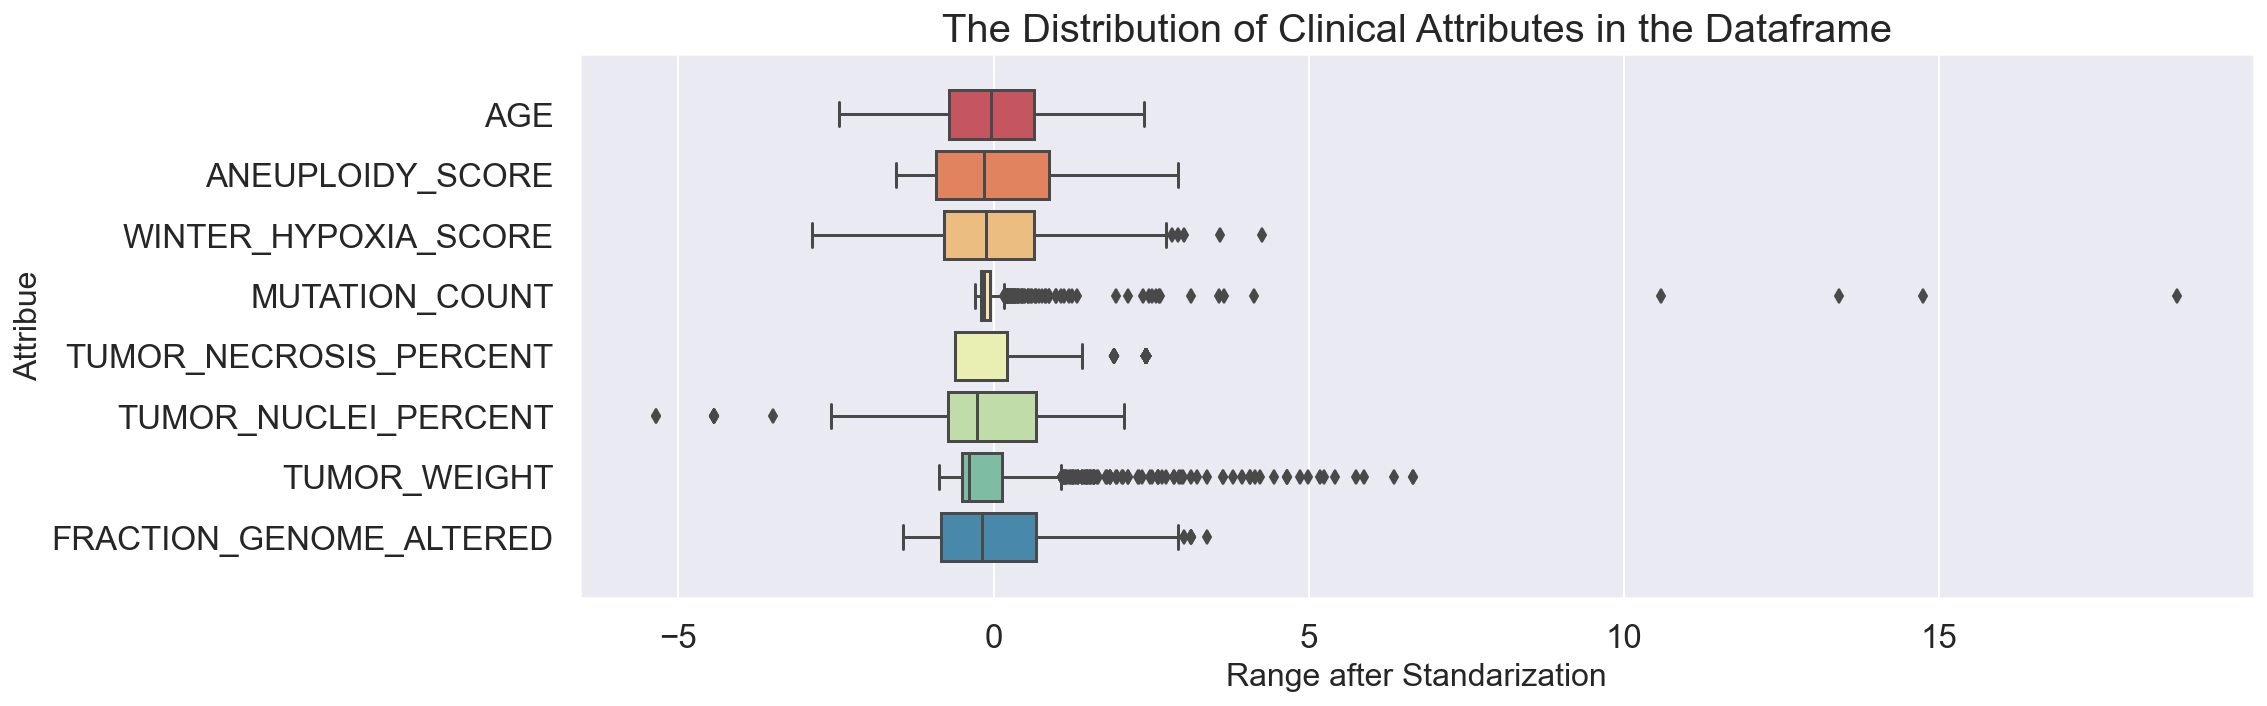

In [1563]:
ax, fig = plt.subplots(1, 1, figsize = (15, 5))
plt.title('The Distribution of Clinical Attributes in the Dataframe', fontsize = 20) #Change please

sns.boxplot(y = "variable", x = "value", data = pd.melt(to_standard(final_df_numerical)), palette = 'Spectral')
plt.xlabel('Range after Standarization', size = 16)
plt.ylabel('Attribue', size = 16)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

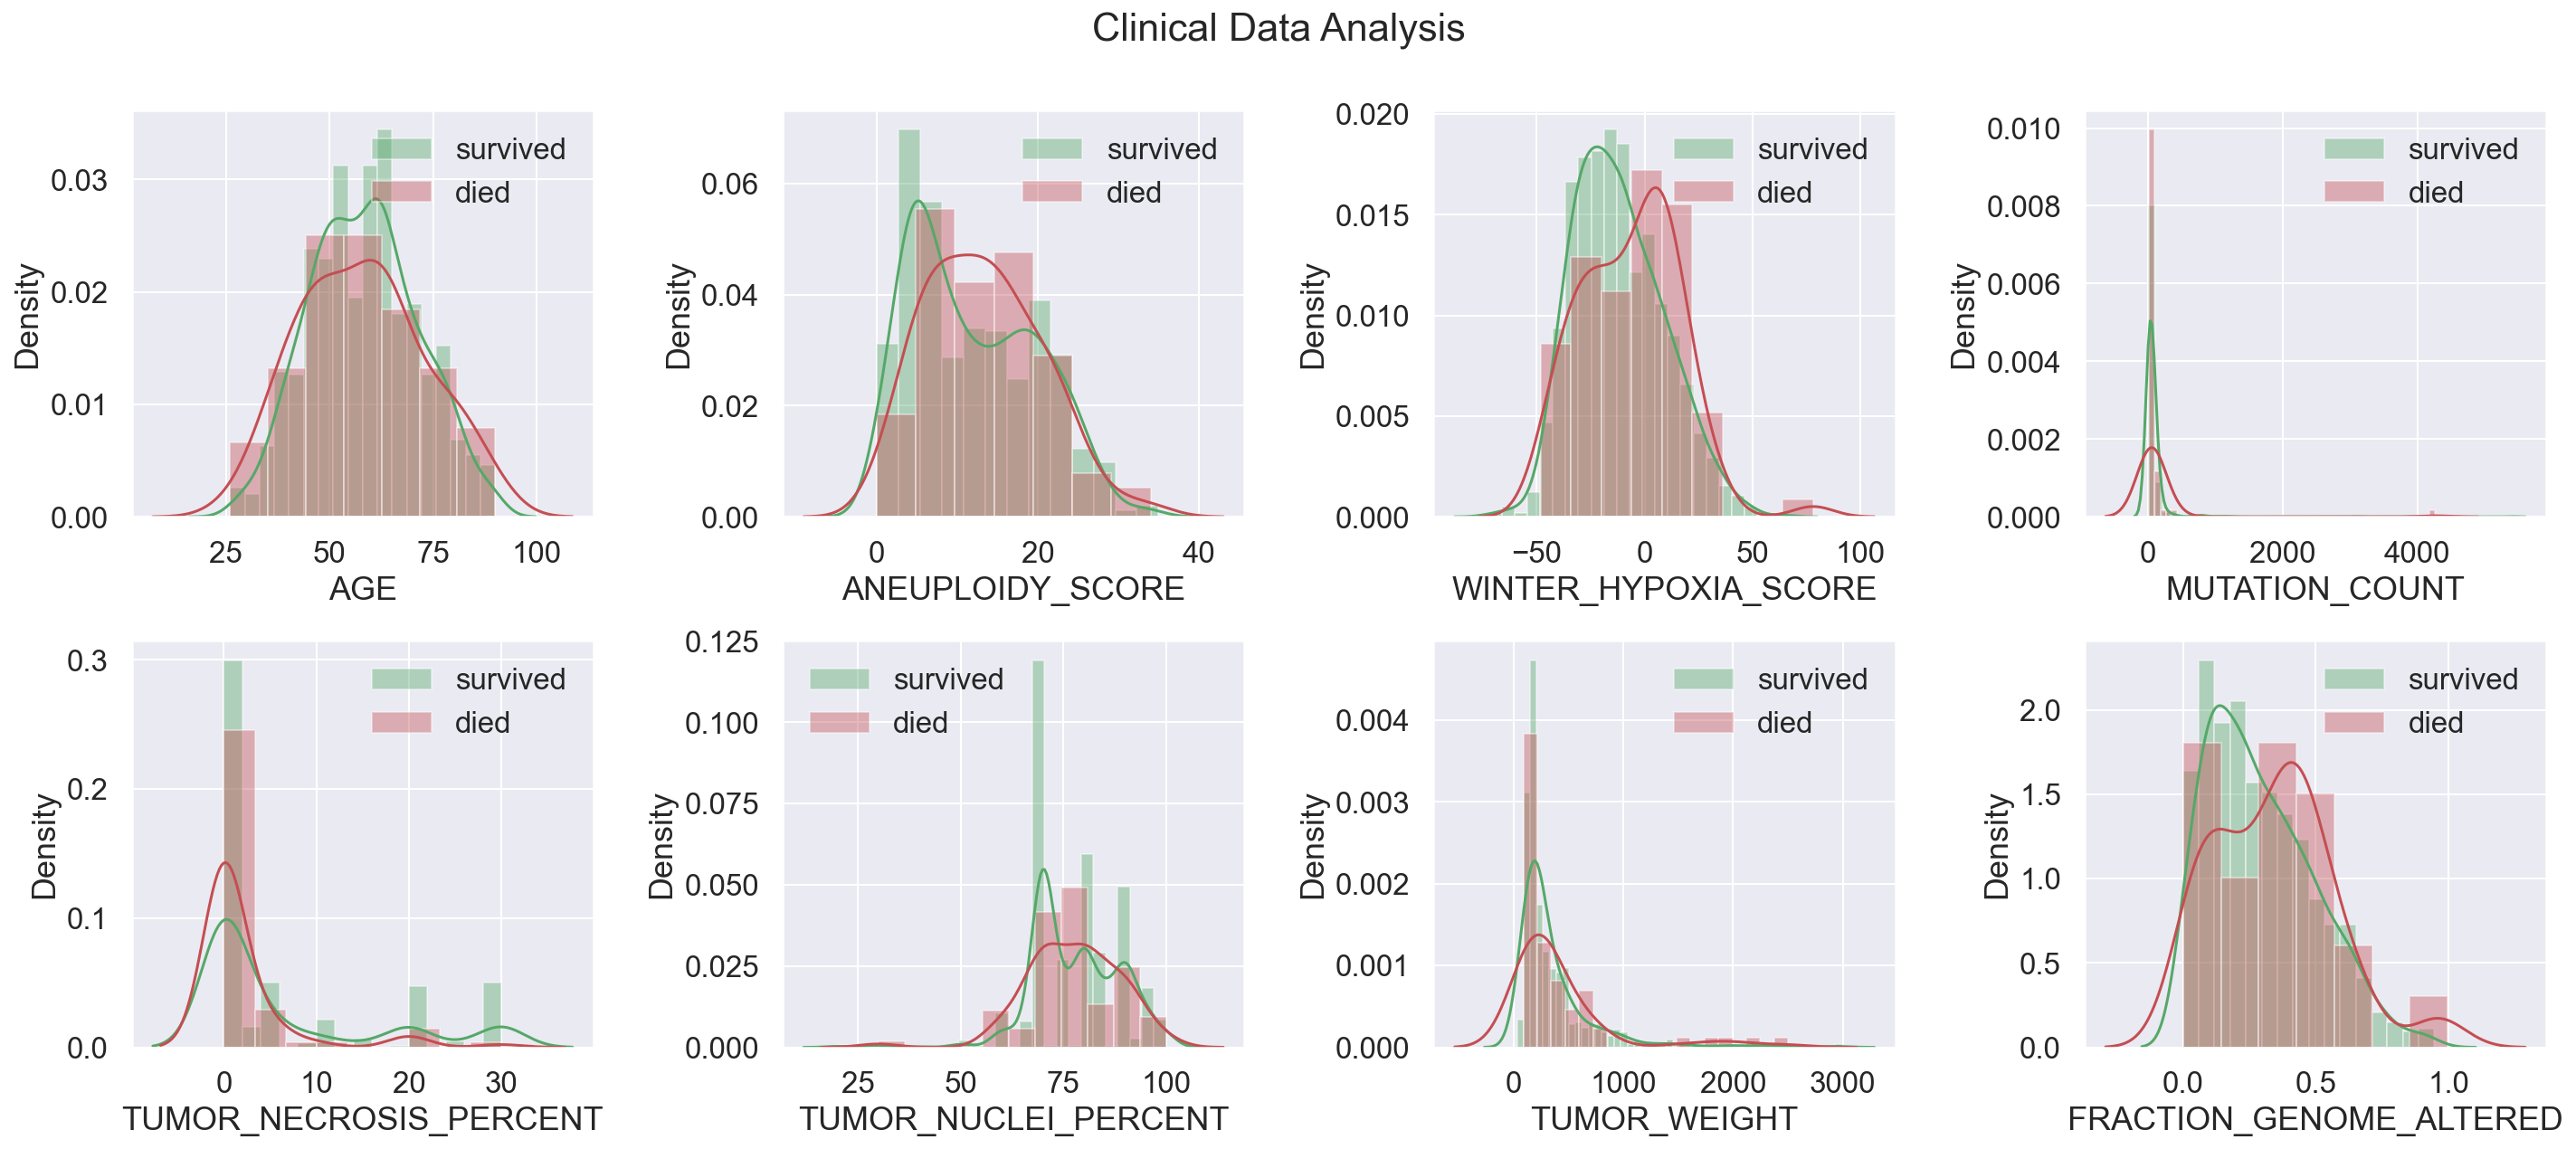

In [1564]:
fig = plt.figure(figsize = (20, 25))
j = 0

for i in final_df_numerical.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(final_df_numerical[i][df['DSS_STATUS']==0], color='g', label = 'survived')
    sns.distplot(final_df_numerical[i][df['DSS_STATUS']==1], color='r', label = 'died')
    plt.legend(loc='best')
fig.suptitle('Clinical Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

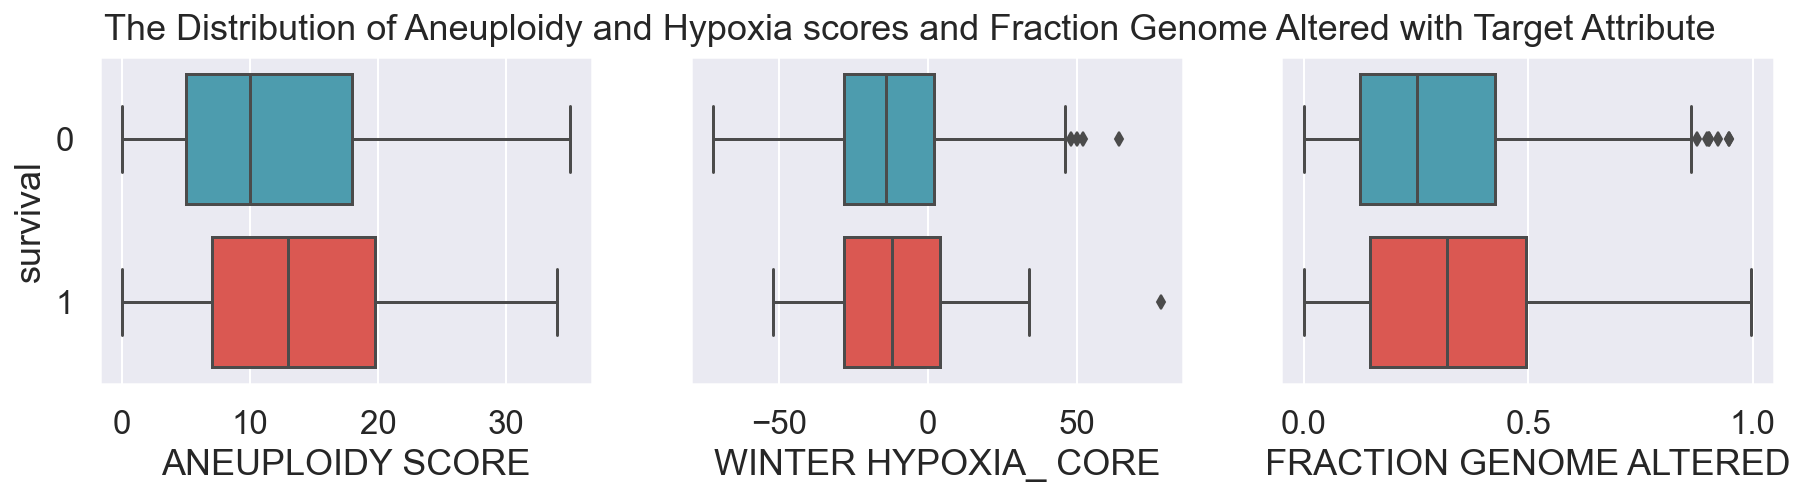

In [1565]:
fig, ax = plt.subplots(ncols=3, figsize=(15,3), sharey=True)

sns.boxplot(x='ANEUPLOIDY_SCORE', y= 'OS_STATUS', orient='h', data=df, ax=ax[0], palette = two_colors, saturation=0.90)

sns.boxplot(x='WINTER_HYPOXIA_SCORE', y='OS_STATUS', orient='h', data=df, ax=ax[1], palette = two_colors, saturation=0.90)

sns.boxplot(x='FRACTION_GENOME_ALTERED', y='OS_STATUS', orient='h', data=df, ax=ax[2], palette = two_colors, saturation=0.90)

fig.suptitle('The Distribution of Aneuploidy and Hypoxia scores and Fraction Genome Altered with Target Attribute', fontsize = 18)

ax[0].set_xlabel('ANEUPLOIDY SCORE')
ax[0].set_ylabel('survival')
ax[1].set_xlabel('WINTER HYPOXIA_ CORE')
ax[1].set_ylabel('')
ax[2].set_xlabel('FRACTION GENOME ALTERED')
ax[2].set_ylabel('')

plt.show()

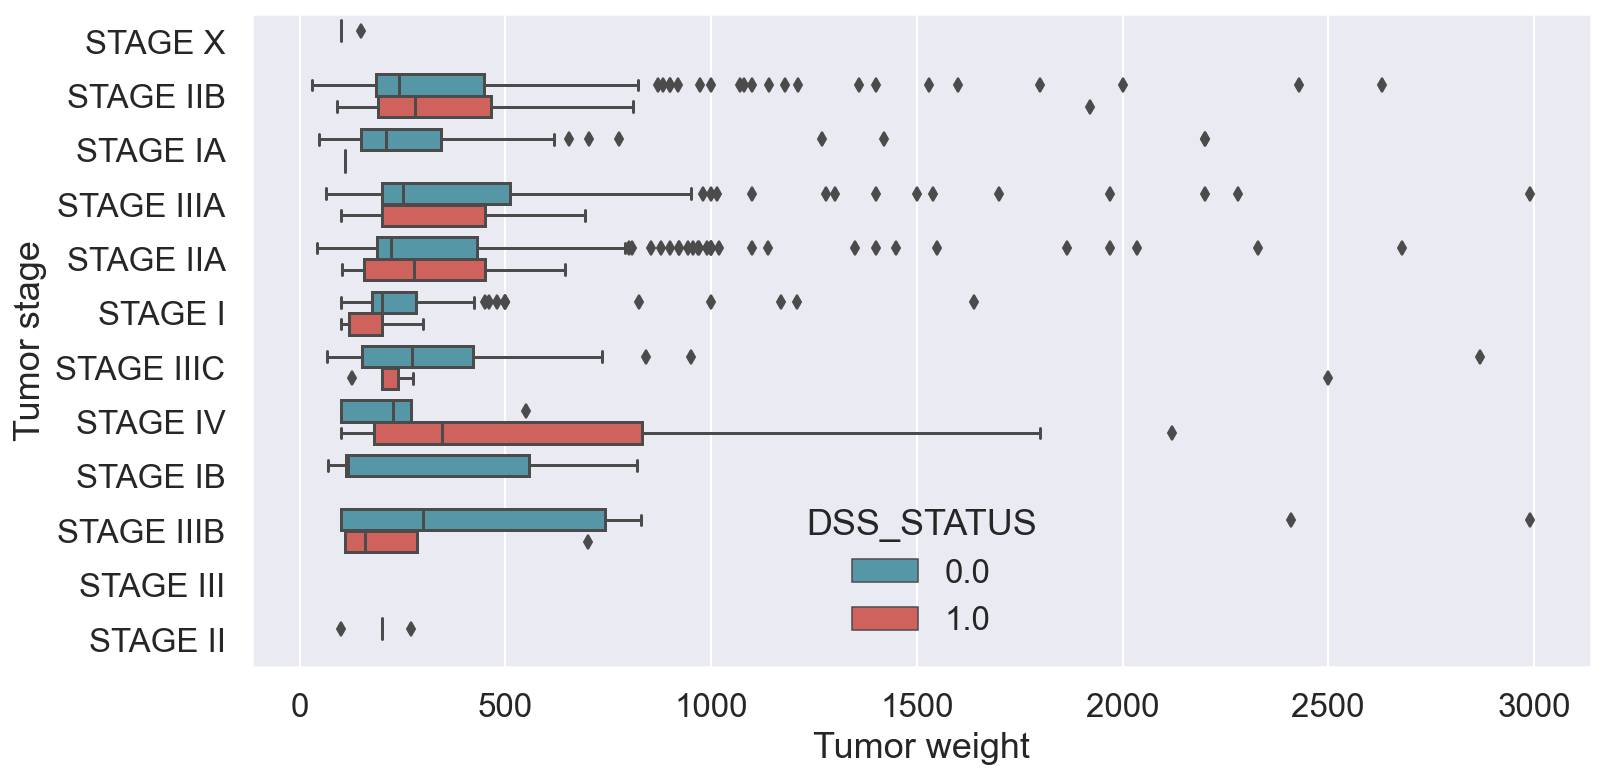

In [1566]:
ig, ax = plt.subplots( figsize=(12, 6))
ax = sns.boxplot(x ='TUMOR_WEIGHT', y ='AJCC_PATHOLOGIC_TUMOR_STAGE',  data = df, orient='h', hue='DSS_STATUS', palette=two_colors)

ax.set_ylabel('Tumor stage')
ax.set_xlabel('Tumor weight')
fig.suptitle('Tumor stage vs. Tumor size and overall_survival', fontsize=20)

#legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [1567]:
final_df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1084 entries, 0 to 1083
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SUBTYPE                      981 non-null    object 
 1   SEX                          1084 non-null   object 
 2   AJCC_PATHOLOGIC_TUMOR_STAGE  1079 non-null   object 
 3   HISTORY_NEOADJUVANT_TRTYN    1083 non-null   object 
 4   ICD_10                       1084 non-null   object 
 5   ICD_O_3_HISTOLOGY            1084 non-null   object 
 6   PATH_M_STAGE                 1084 non-null   object 
 7   PATH_N_STAGE                 1084 non-null   object 
 8   PATH_T_STAGE                 1084 non-null   object 
 9   PRIOR_DX                     1083 non-null   object 
 10  RACE                         994 non-null    object 
 11  OS_STATUS                    1084 non-null   int64  
 12  ONCOTREE_CODE                1084 non-null   object 
 13  TUMOR_TYPE        

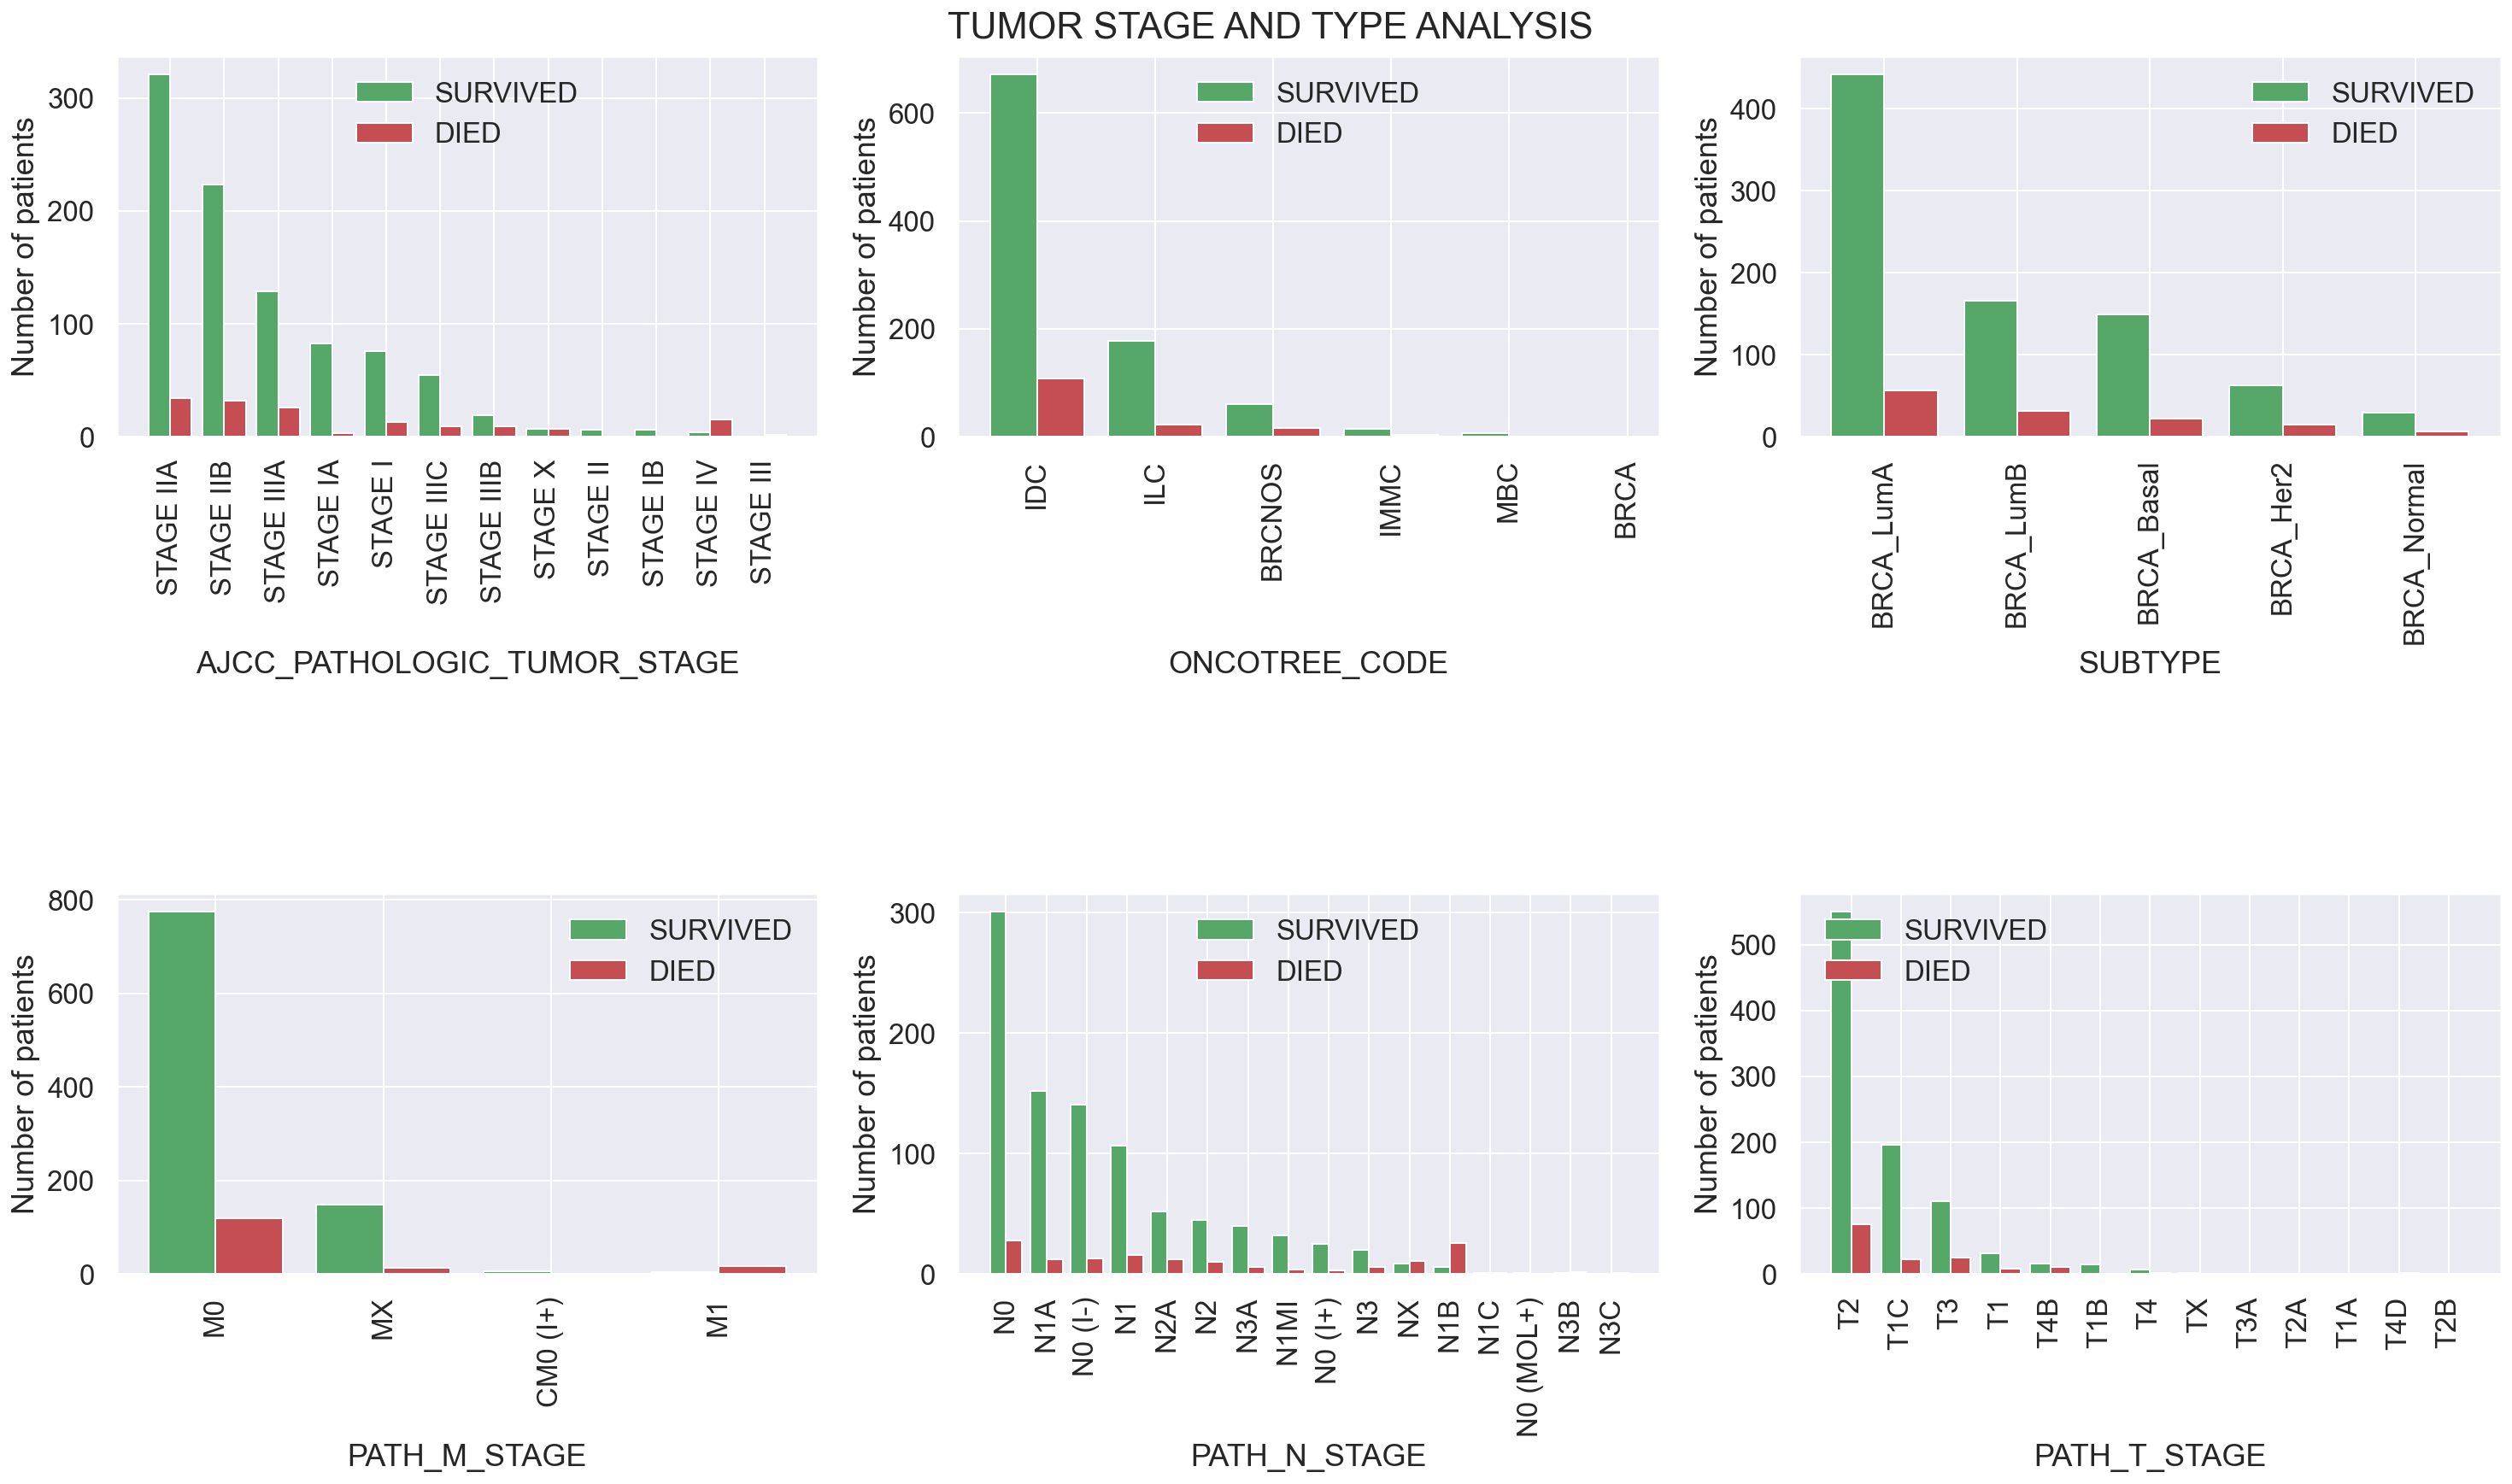

In [1568]:
final_df_categorical2 = final_df_categorical[['OS_STATUS', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'ONCOTREE_CODE', 'SUBTYPE', 'PATH_M_STAGE', 'PATH_N_STAGE', 'PATH_T_STAGE']]

died = final_df_categorical2[final_df_categorical2['OS_STATUS']==1]
survived = final_df_categorical2[final_df_categorical2['OS_STATUS']==0]
died.drop(labels =['OS_STATUS'], axis=1, inplace=True)
survived.drop(labels =['OS_STATUS'], axis=1, inplace=True)

fig = plt.figure(figsize = (25, 12))
fig.suptitle('TUMOR STAGE AND TYPE ANALYSIS')
fig.tight_layout()
fig.subplots_adjust(top=0.95, hspace=1.2)
j = 0

for i in survived.columns:

    plt.subplot(2, 3, j+1)
    j += 1

    dfs = pd.DataFrame(survived[i].value_counts()).reset_index()
    dfs.columns = [i, 'COUNT']
    dfs['% to total survived'] = dfs['COUNT']*100/ sum(dfs['COUNT'])


    dfd = pd.DataFrame(died[i].value_counts()).reset_index()
    dfd.columns = [i, 'COUNT']
    dfd['% to total died'] = dfd['COUNT']*100/ sum(dfd['COUNT'])


    dfall = dfs.merge(dfd, on= i, how='outer')
    dfall.columns = [i, 'COUNT_SURVIVED', '% to total survived', 'COUNT_DIED', '% to total died']

  
    X_axis = np.arange(len(dfall[i].to_list()))
  
    plt.bar(X_axis - 0.2, dfall['COUNT_SURVIVED'].to_list(), 0.4, label = 'SURVIVED', color = 'g')
    plt.bar(X_axis + 0.2, dfall['COUNT_DIED'].to_list(), 0.4, label = 'DIED', color = 'r')
  
    plt.xticks(X_axis, dfall[i].to_list(), rotation = '90')
    plt.xlabel(i)
    plt.legend(loc = 'best')
    plt.ylabel('Number of patients')

fig.align_labels()
plt.show()



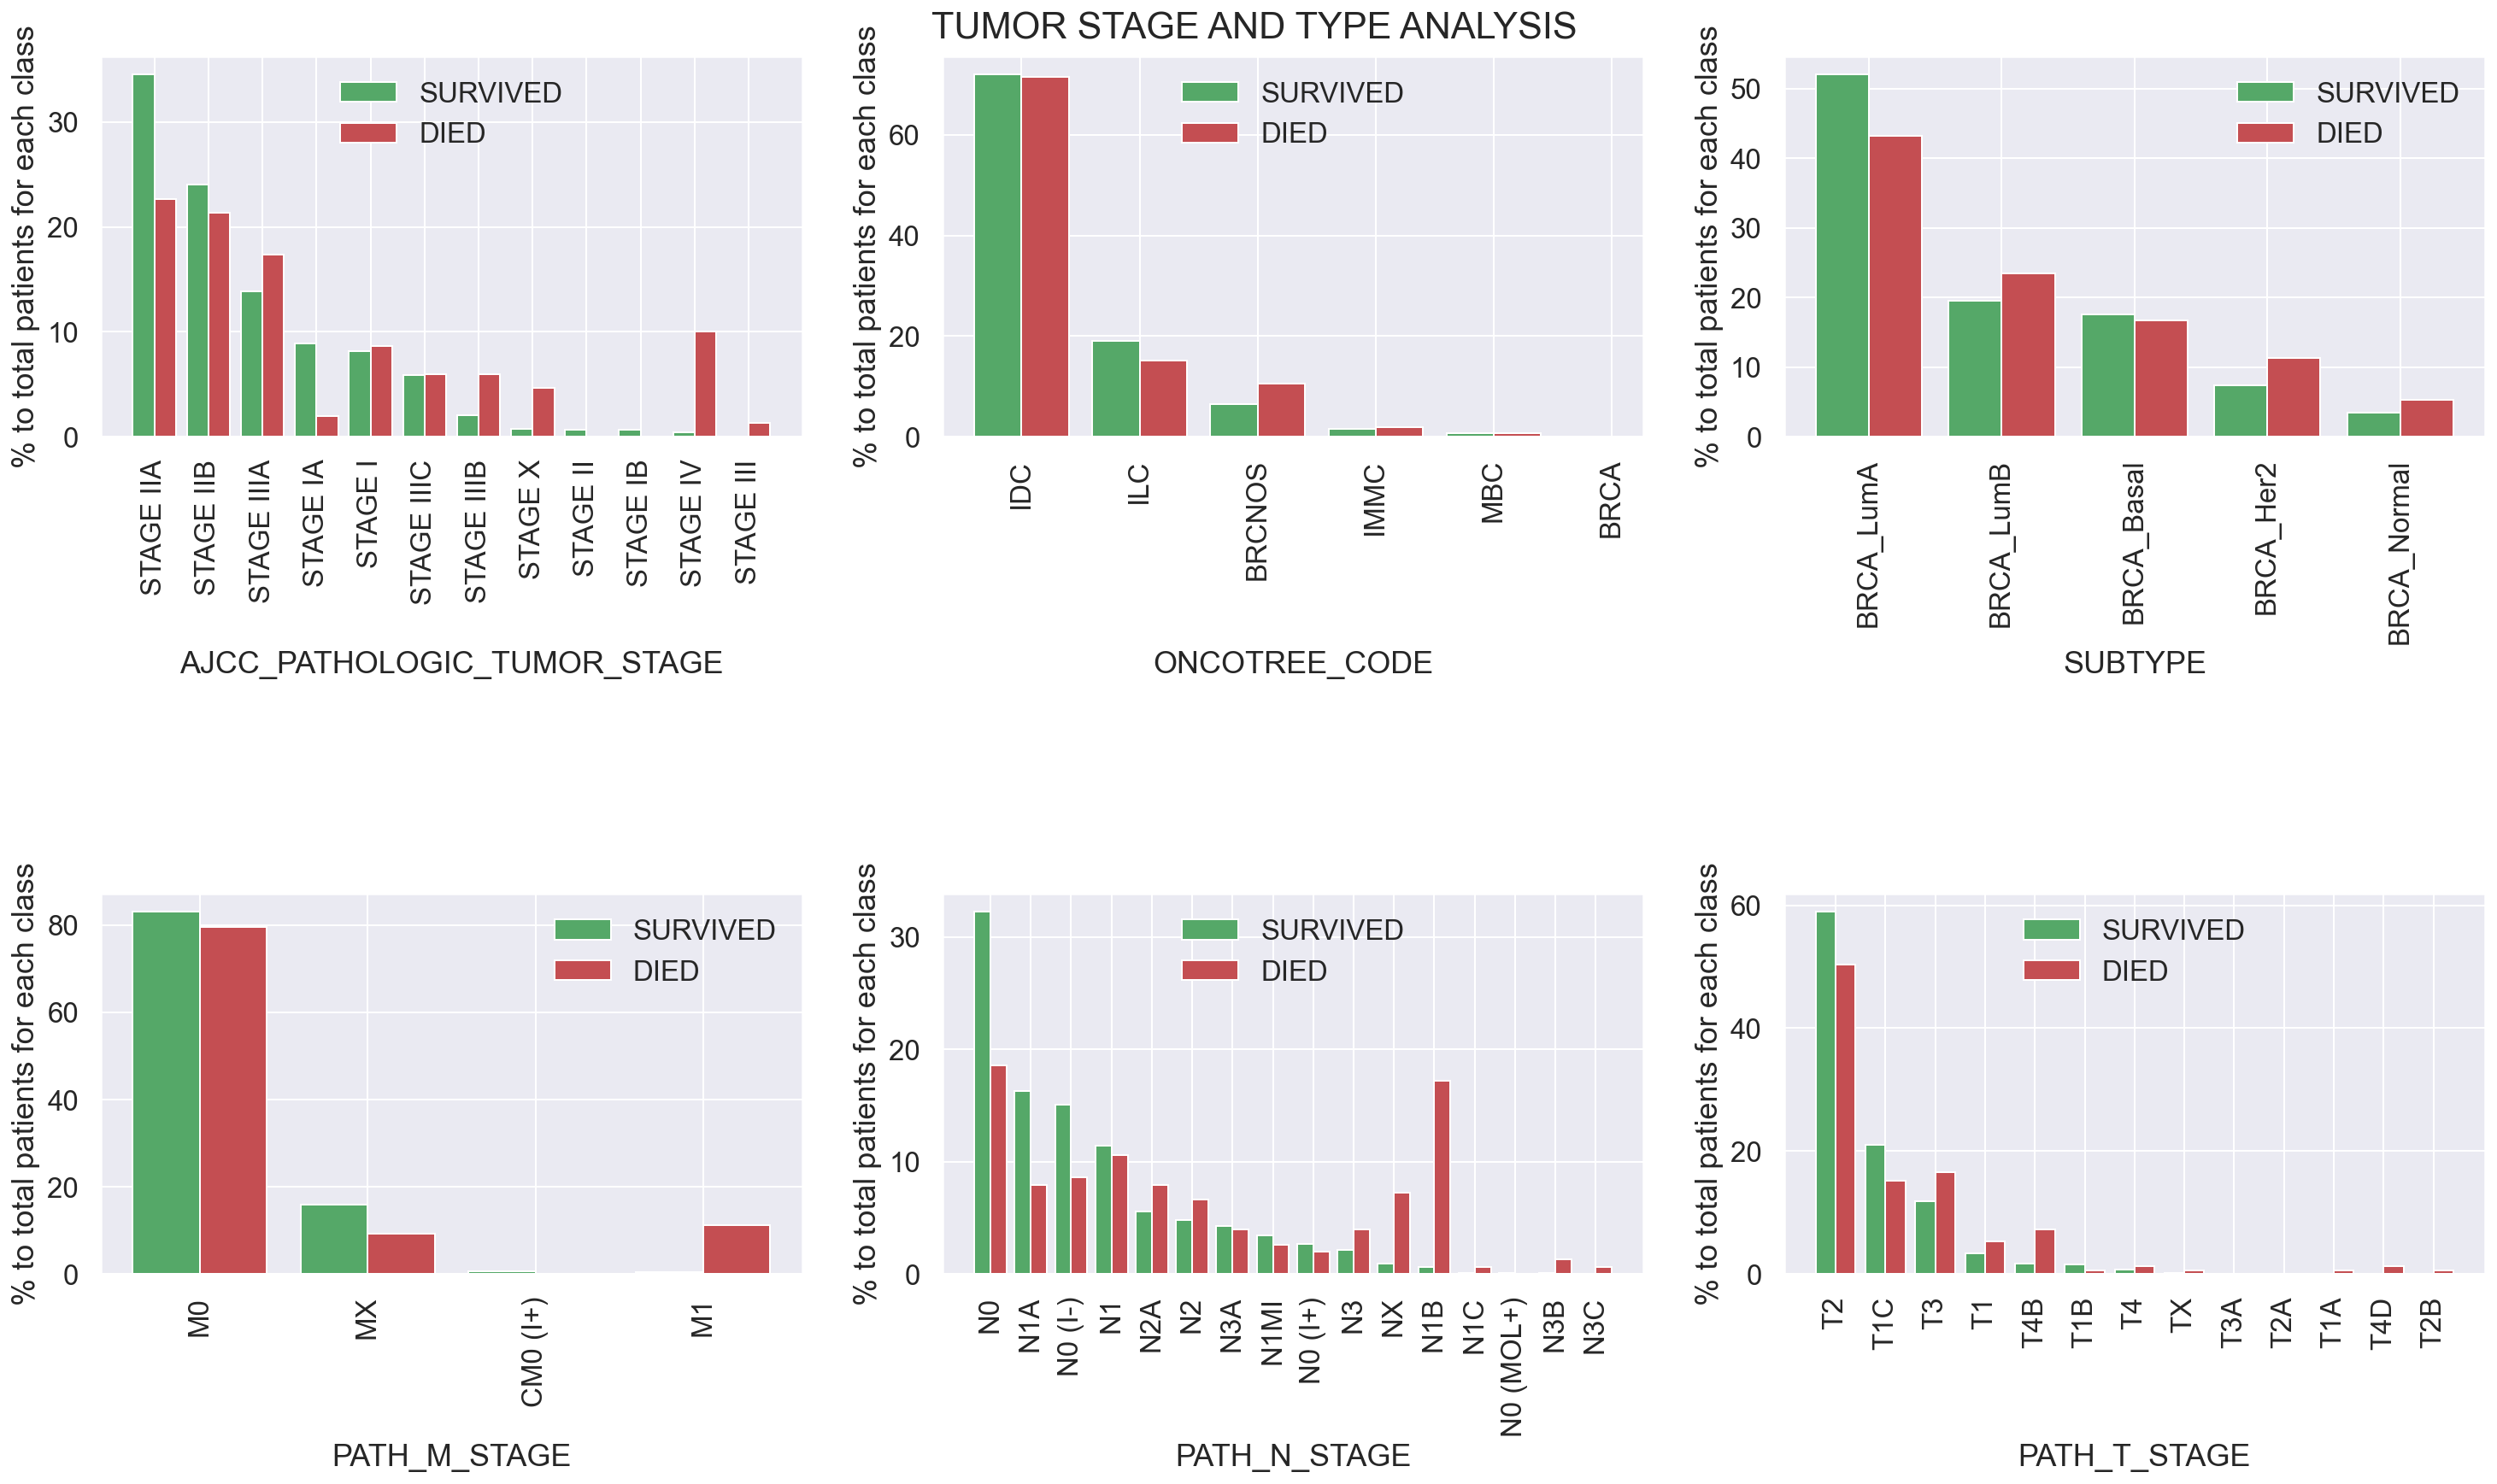

In [1569]:
fig = plt.figure(figsize = (25, 12))
fig.suptitle('TUMOR STAGE AND TYPE ANALYSIS')
fig.tight_layout()
fig.subplots_adjust(top=0.95, hspace=1.2)
j = 0

for i in survived.columns:

    plt.subplot(2, 3, j+1)
    j += 1

    dfs = pd.DataFrame(survived[i].value_counts()).reset_index()
    dfs.columns = [i, 'COUNT']
    dfs['% to total survived'] = dfs['COUNT']*100/ sum(dfs['COUNT'])


    dfd = pd.DataFrame(died[i].value_counts()).reset_index()
    dfd.columns = [i, 'COUNT']
    dfd['% to total died'] = dfd['COUNT']*100/ sum(dfd['COUNT'])


    dfall = dfs.merge(dfd, on= i, how='outer')
    dfall.columns = [i, 'COUNT_SURVIVED', '% to total survived', 'COUNT_DIED', '% to total died']

  
    X_axis = np.arange(len(dfall[i].to_list()))
  
    plt.bar(X_axis - 0.2, dfall['% to total survived'].to_list(), 0.4, label = 'SURVIVED', color = 'g')
    plt.bar(X_axis + 0.2, dfall['% to total died'].to_list(), 0.4, label = 'DIED', color = 'r')
  
    plt.xticks(X_axis, dfall[i].to_list(), rotation = '90')
    plt.xlabel(i)
    plt.legend(loc = 'best')
    plt.ylabel('% to total patients for each class')

fig.align_labels()
plt.show()

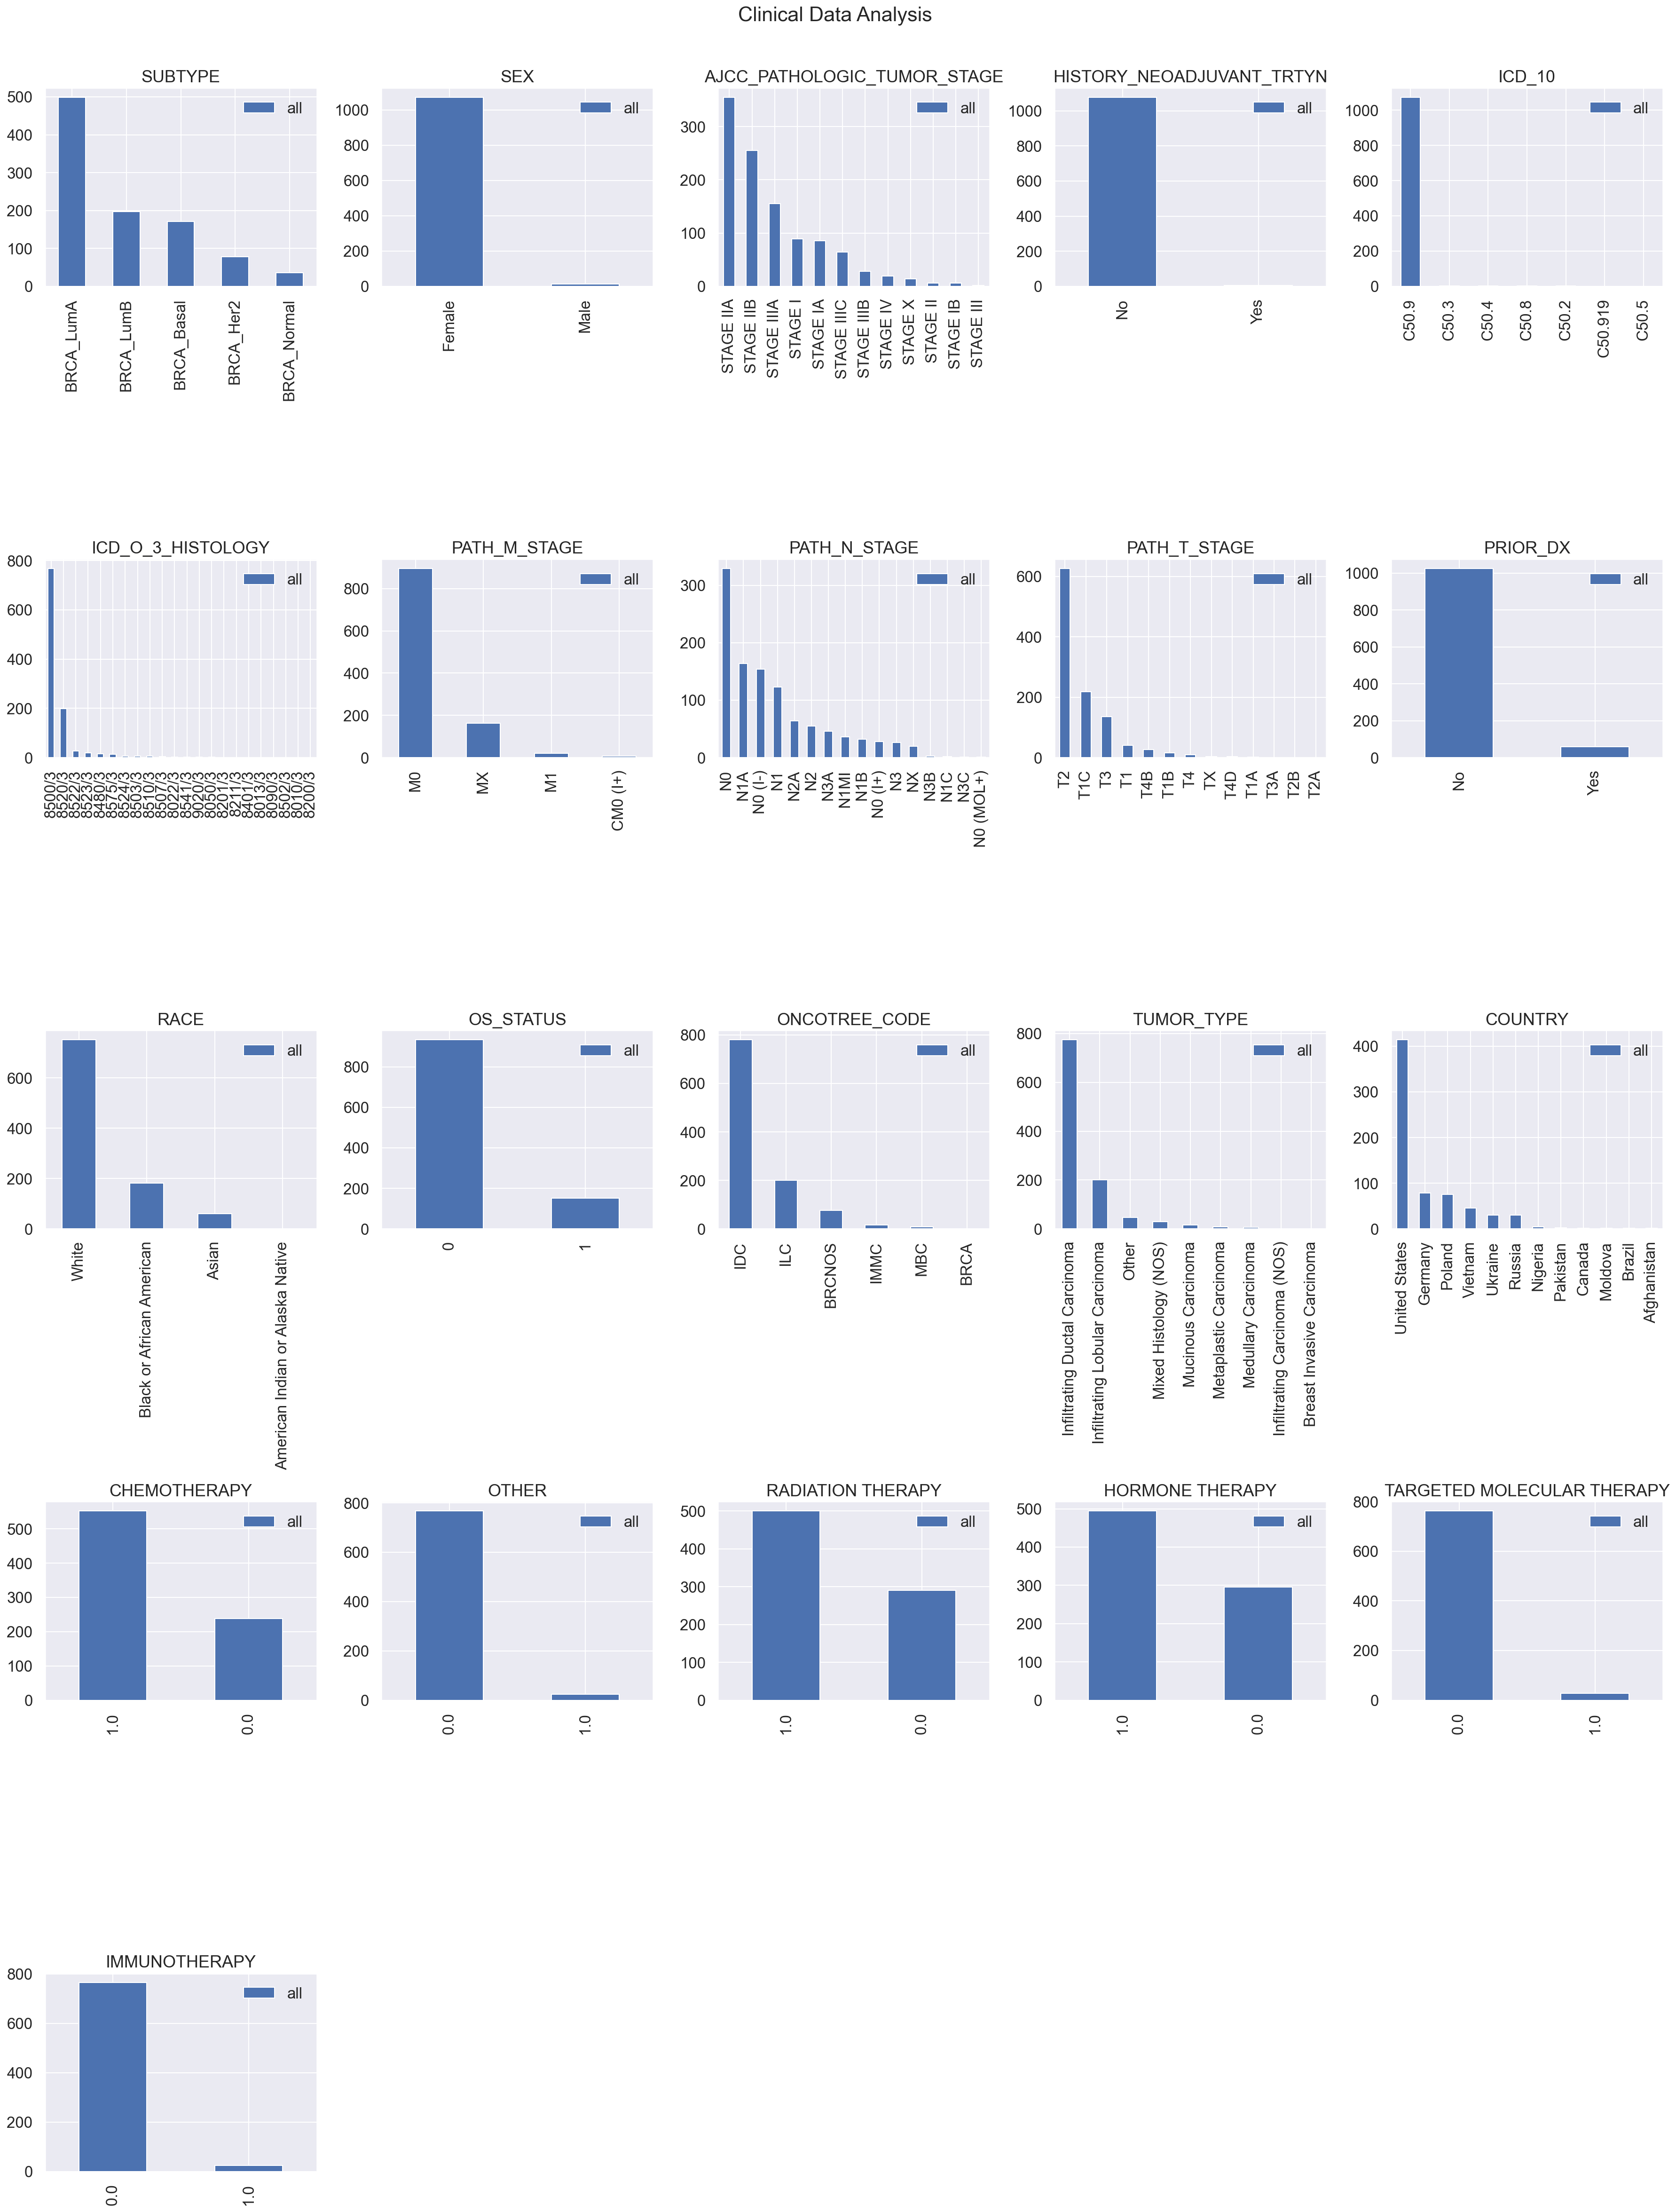

In [1570]:
fig = plt.figure(figsize = (25, 40))
j = 0

for i in final_df_categorical.columns:
    plt.subplot(6, 5, j+1)
    j += 1
    final_df_categorical[i].value_counts().plot.bar(rot=0, color='b', label = 'all', subplots=True)
    plt.legend(loc='best')
    plt.xticks(rotation = '90')
    plt.title(i)

fig.suptitle('Clinical Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [1571]:
df = df.drop(labels = ['DSS_STATUS','OS_MONTHS', 'DSS_MONTHS','DFS_STATUS','DFS_MONTHS', 'PFS_STATUS', 'PFS_MONTHS'], axis=1)
Corr_survival = df.corr()['OS_STATUS'].sort_values(ascending = False)
Corr_df = pd.DataFrame({'Correlation':Corr_survival})
Corr_df

,Correlation
OS_STATUS,1.000000
AGE,0.085183
FRACTION_GENOME_ALTERED,0.077616
ANEUPLOIDY_SCORE,0.066092
OTHER,0.065366
IMMUNOTHERAPY,0.033880
TUMOR_WEIGHT,0.022948
HORMONE THERAPY,0.020954
WINTER_HYPOXIA_SCORE,0.011220
MUTATION_COUNT,0.007373


In [1572]:
# Statistical summary for clinical attributes 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,1084.0,58.420664,13.219721,26.0,49.0000,58.0000,67.000000,90.0000
OS_STATUS,1084.0,0.139299,0.346418,0.0,0.0000,0.0000,0.000000,1.0000
ANEUPLOIDY_SCORE,1041.0,12.122959,7.818510,0.0,5.0000,11.0000,19.000000,35.0000
WINTER_HYPOXIA_SCORE,1079.0,-11.471733,21.017858,-72.0,-28.0000,-14.0000,2.000000,78.0000
MUTATION_COUNT,1009.0,83.455897,283.142180,1.0,26.0000,39.0000,68.000000,5399.0000
TUMOR_NECROSIS_PERCENT,1080.0,6.086574,9.888215,0.0,0.0000,0.0000,8.250000,30.0000
TUMOR_NUCLEI_PERCENT,1080.0,77.741667,10.776649,20.0,70.0000,75.0000,85.000000,100.0000
TUMOR_WEIGHT,1025.0,371.026341,393.372786,31.0,175.0000,218.0000,423.000000,2990.0000
CHEMOTHERAPY,790.0,0.698734,0.459099,0.0,0.0000,1.0000,1.000000,1.0000
OTHER,790.0,0.029114,0.168232,0.0,0.0000,0.0000,0.000000,1.0000


In [1573]:
#what the average patient looks like
print("Mean age: " + "%.3f" %np.mean(df['AGE']))
print("Most occurring tumour stage: " , stats.mode(df['AJCC_PATHOLOGIC_TUMOR_STAGE'])[0][0])
print("Most occurring sex: " , stats.mode(df['SEX'])[0][0])
print("Most occurring ethnicity: " , stats.mode(df['RACE'])[0][0])
print("Mean tumour weight: " + "%.3f" %np.mean(df['TUMOR_WEIGHT']))
print("Probability of death: "+ "%.3f" %(df["OS_STATUS"].value_counts()/df["OS_STATUS"].count()).iloc[1])

Mean age: 58.421
Most occurring tumour stage:  STAGE IIA
Most occurring sex:  Female
Most occurring ethnicity:  White
Mean tumour weight: 371.026
Probability of death: 0.139


In [1574]:
#Finding number of outliers in each column
Q1 = df2.quantile(0.25)
Q3 = df2.quantile(0.75)
IQR = Q3 - Q1
((df2 < (Q1 - 1.5 * IQR)) | (df2 > (Q3 + 1.5 * IQR))).sum().sort_values(ascending = False).head(10)

OS_STATUS                     151
TUMOR_NECROSIS_PERCENT        108
TUMOR_WEIGHT                  101
MUTATION_COUNT                93 
TARGETED MOLECULAR THERAPY    28 
IMMUNOTHERAPY                 24 
OTHER                         23 
TUMOR_NUCLEI_PERCENT          8  
FRACTION_GENOME_ALTERED       6  
WINTER_HYPOXIA_SCORE          5  
dtype: int64

In [1575]:
print('Baseline accuracy:' )
print(df["OS_STATUS"].value_counts()/df["OS_STATUS"].count())

Baseline accuracy:
0    0.860701
1    0.139299
Name: OS_STATUS, dtype: float64


In [1576]:
for i in final_df_numerical.columns:
    df[i].fillna(df[i].mean(), inplace=True)

In [1577]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1084 entries, 0 to 1083
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SUBTYPE                      981 non-null    object 
 1   AGE                          1084 non-null   int64  
 2   SEX                          1084 non-null   object 
 3   AJCC_PATHOLOGIC_TUMOR_STAGE  1079 non-null   object 
 4   HISTORY_NEOADJUVANT_TRTYN    1083 non-null   object 
 5   ICD_10                       1084 non-null   object 
 6   ICD_O_3_HISTOLOGY            1084 non-null   object 
 7   PATH_M_STAGE                 1084 non-null   object 
 8   PATH_N_STAGE                 1084 non-null   object 
 9   PATH_T_STAGE                 1084 non-null   object 
 10  PRIOR_DX                     1083 non-null   object 
 11  RACE                         994 non-null    object 
 12  OS_STATUS                    1084 non-null   int64  
 13  ONCOTREE_CODE     

In [1578]:
dummies = df[['CHEMOTHERAPY', 'RADIATION THERAPY', 'HORMONE THERAPY', 'IMMUNOTHERAPY', 'TARGETED MOLECULAR THERAPY', 'OTHER']]

In [1579]:
for i in dummies.columns:
    df["{} NA".format(i)] = np.where(df[i].isnull(), 1, 0)
    df[i].fillna(0, inplace=True)


In [1580]:
def replace_missing_data(df, mis_vars):
    print('##### Replacing missing values with mode of features #####')
    for var in mis_vars:
        df[var] = df[var].fillna(df[var].mode()[0])
    return df

In [1581]:
mis_var = [var for var in df.columns if df[var].isnull().sum() > 0]
df= replace_missing_data(df, mis_var)
df.head()

##### Replacing missing values with mode of features #####


,SUBTYPE,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,HISTORY_NEOADJUVANT_TRTYN,ICD_10,ICD_O_3_HISTOLOGY,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,...,HORMONE THERAPY,TARGETED MOLECULAR THERAPY,IMMUNOTHERAPY,FRACTION_GENOME_ALTERED,CHEMOTHERAPY NA,RADIATION THERAPY NA,HORMONE THERAPY NA,IMMUNOTHERAPY NA,TARGETED MOLECULAR THERAPY NA,OTHER NA
0,BRCA_LumA,55,Female,STAGE X,No,C50.9,8520/3,MX,NX,TX,...,0.0,0.0,0.0,0.7787,0,0,0,0,0,0
1,BRCA_Her2,50,Female,STAGE IIB,No,C50.9,8500/3,M0,N1A,T2,...,0.0,0.0,0.0,0.7164,0,0,0,0,0,0
2,BRCA_LumB,62,Female,STAGE IIB,No,C50.9,8500/3,M0,N1A,T2,...,0.0,0.0,0.0,0.5340,0,0,0,0,0,0
3,BRCA_LumA,52,Female,STAGE IA,No,C50.9,8500/3,M0,N0 (I+),T1C,...,0.0,0.0,0.0,0.0764,0,0,0,0,0,0
4,BRCA_LumA,50,Female,STAGE IIIA,No,C50.9,8520/3,M0,N2A,T2,...,0.0,0.0,0.0,0.2364,0,0,0,0,0,0


In [1582]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1084 entries, 0 to 1083
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SUBTYPE                        1084 non-null   object 
 1   AGE                            1084 non-null   int64  
 2   SEX                            1084 non-null   object 
 3   AJCC_PATHOLOGIC_TUMOR_STAGE    1084 non-null   object 
 4   HISTORY_NEOADJUVANT_TRTYN      1084 non-null   object 
 5   ICD_10                         1084 non-null   object 
 6   ICD_O_3_HISTOLOGY              1084 non-null   object 
 7   PATH_M_STAGE                   1084 non-null   object 
 8   PATH_N_STAGE                   1084 non-null   object 
 9   PATH_T_STAGE                   1084 non-null   object 
 10  PRIOR_DX                       1084 non-null   object 
 11  RACE                           1084 non-null   object 
 12  OS_STATUS                      1084 non-null   i

In [1583]:
cat_vars = [var for var in df.columns if df[var].dtypes == 'O']
cat_vars 

['SUBTYPE',
 'SEX',
 'AJCC_PATHOLOGIC_TUMOR_STAGE',
 'HISTORY_NEOADJUVANT_TRTYN',
 'ICD_10',
 'ICD_O_3_HISTOLOGY',
 'PATH_M_STAGE',
 'PATH_N_STAGE',
 'PATH_T_STAGE',
 'PRIOR_DX',
 'RACE',
 'ONCOTREE_CODE',
 'TUMOR_TYPE',
 'COUNTRY']

In [1584]:
def encode_categorical_variables(df, cat_vars):
    print('Categorical variables: ', cat_vars)
    for i in range(len(cat_vars)):
        var = cat_vars[i]
        var_le = LabelEncoder()
        var_labels = var_le.fit_transform(df[var])
        var_mappings = {index: label for index, label in enumerate(var_le.classes_)}
        df[(var + '_labels')] = var_labels
        df.drop(columns=var, axis=1, inplace=True)
    return df, var_mappings

In [1585]:
df = encode_categorical_variables(df, cat_vars)
# df.head(10)

Categorical variables:  ['SUBTYPE', 'SEX', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'HISTORY_NEOADJUVANT_TRTYN', 'ICD_10', 'ICD_O_3_HISTOLOGY', 'PATH_M_STAGE', 'PATH_N_STAGE', 'PATH_T_STAGE', 'PRIOR_DX', 'RACE', 'ONCOTREE_CODE', 'TUMOR_TYPE', 'COUNTRY']


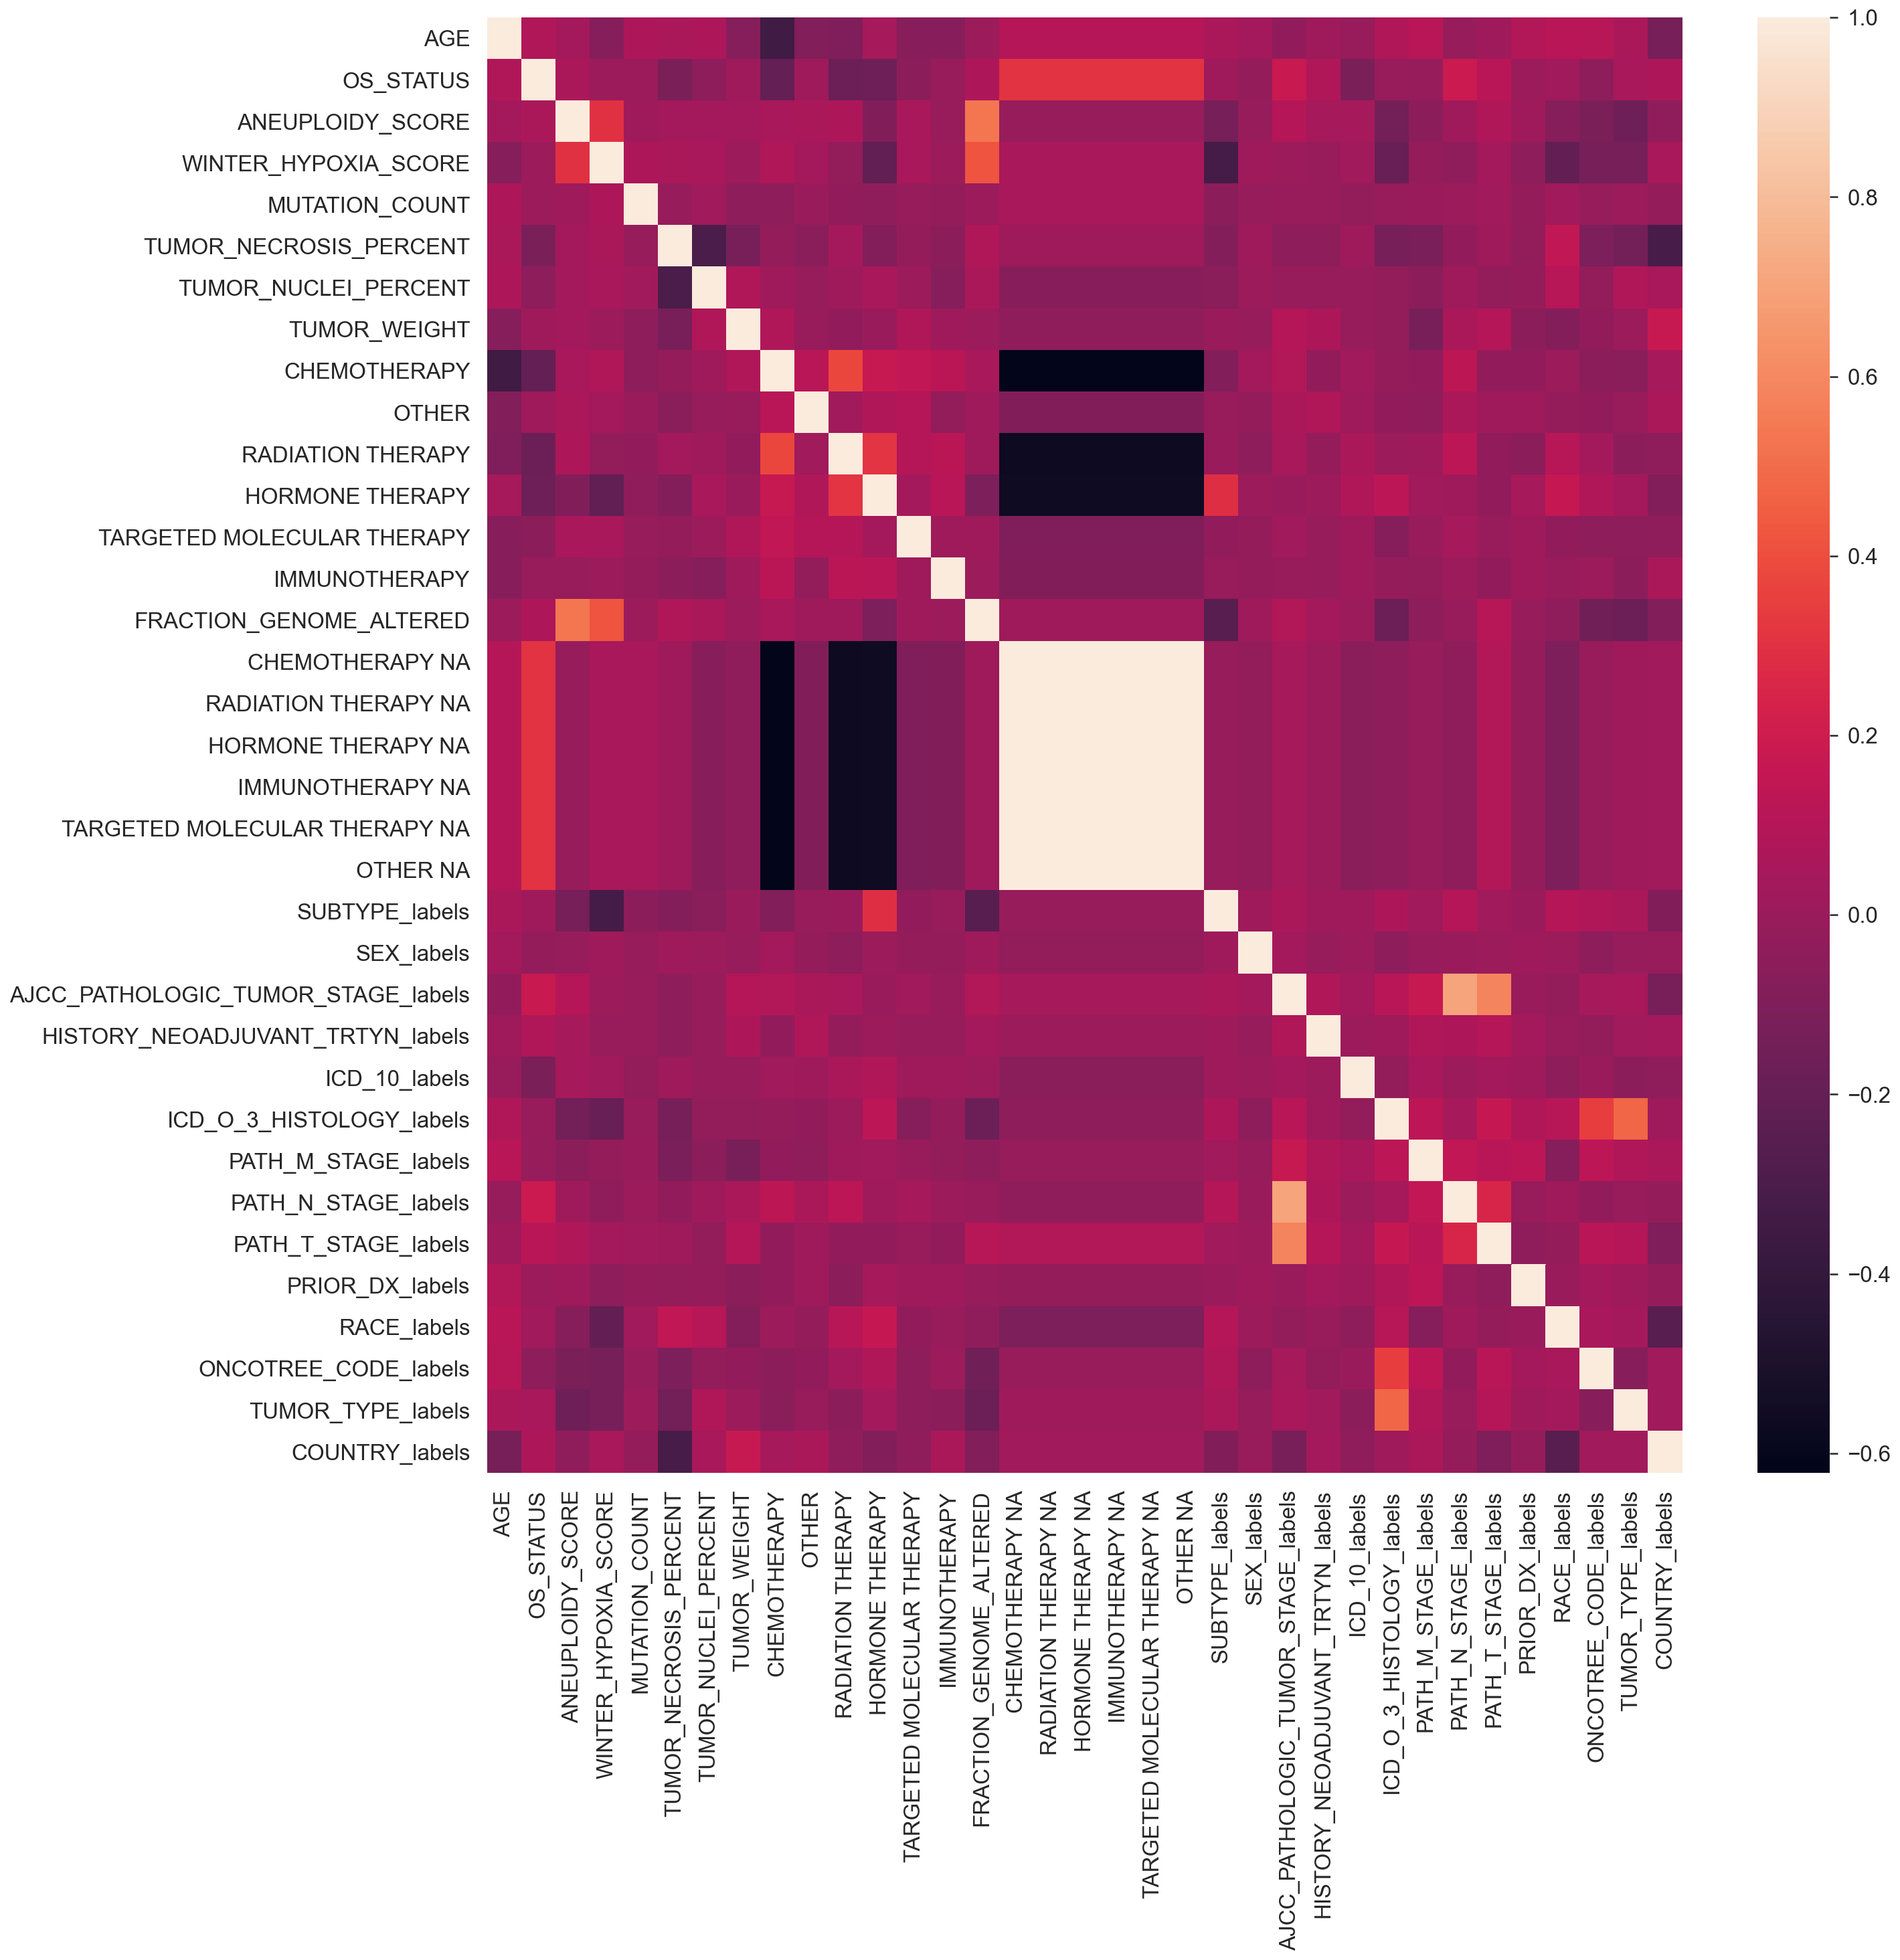

In [1586]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr())
plt.show()

In [1587]:
df.to_excel('/Users/Marta/Desktop/df.xlsx', index=False)

### MODEL

In [1588]:
df = pd.read_excel('/Users/Marta/Desktop/df.xlsx')

In [1589]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   AGE                                 1084 non-null   int64  
 1   OS_STATUS                           1084 non-null   int64  
 2   ANEUPLOIDY_SCORE                    1084 non-null   float64
 3   WINTER_HYPOXIA_SCORE                1084 non-null   float64
 4   MUTATION_COUNT                      1084 non-null   float64
 5   TUMOR_NECROSIS_PERCENT              1084 non-null   float64
 6   TUMOR_NUCLEI_PERCENT                1084 non-null   float64
 7   TUMOR_WEIGHT                        1084 non-null   float64
 8   CHEMOTHERAPY                        1084 non-null   int64  
 9   OTHER                               1084 non-null   int64  
 10  RADIATION THERAPY                   1084 non-null   int64  
 11  HORMONE THERAPY                     1084 no